https://github.com/DataTalksClub/machine-learning-zoomcamp/blob/master/cohorts/2025/06-trees/homework.md

In [1]:
from tqdm import tqdm

In [2]:
import numpy as np
import pandas as pd

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error

In [4]:
import xgboost as xgb

In [5]:
# !wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv -P data

In [6]:
df = pd.read_csv('data/car_fuel_efficiency.csv')
print(df.shape)
df.head()

(9704, 11)


,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,NaN,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369


### Preparing the dataset

In [7]:
target = 'fuel_efficiency_mpg'

In [8]:
cat_columns = df.select_dtypes('object').columns.to_list()
for col in cat_columns:
    print(df[col].value_counts())
    print()

origin
Europe    3254
Asia      3247
USA       3203
Name: count, dtype: int64

fuel_type
Gasoline    4898
Diesel      4806
Name: count, dtype: int64

drivetrain
All-wheel drive      4876
Front-wheel drive    4828
Name: count, dtype: int64



In [9]:
df.isna().sum()

engine_displacement      0
num_cylinders          482
horsepower             708
vehicle_weight           0
acceleration           930
model_year               0
origin                   0
fuel_type                0
drivetrain               0
num_doors              502
fuel_efficiency_mpg      0
dtype: int64

In [10]:
# Fill missing values with zeros
df.fillna(0, inplace=True)

In [11]:
# Do train/validation/test split with 60%/20%/20% distribution.
# Use the train_test_split function and set the random_state parameter to 1.
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)
df_train.shape, df_val.shape, df_test.shape

((5822, 11), (1941, 11), (1941, 11))

In [12]:
y_train = df_train.pop(target).values
y_val = df_val.pop(target).values
y_test = df_test.pop(target).values

In [13]:
# Use DictVectorizer(sparse=True) to turn the dataframes into matrices.
train_dicts = df_train.to_dict(orient='records')
val_dicts = df_val.to_dict(orient='records')
test_dicts = df_test.to_dict(orient='records')

dv = DictVectorizer(sparse=True)
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)
X_test = dv.transform(test_dicts)

X_train.shape, X_val.shape, X_test.shape

((5822, 14), (1941, 14), (1941, 14))

### Question 1

Let's train a decision tree regressor to predict the `fuel_efficiency_mpg` variable

Train a model with `max_depth=1`.

In [14]:
# Which feature is used for splitting the data?
model = DecisionTreeRegressor(max_depth=1)
model.fit(X_train, y_train)
print(export_text(model, feature_names=dv.feature_names_))

|--- vehicle_weight <= 3022.11
|   |--- value: [16.88]
|--- vehicle_weight >  3022.11
|   |--- value: [12.94]



Ans: vehicle_weight

### Question 2

Train a random forest regressor with these parameters:
* n_estimators=10
* random_state=1
* n_jobs=-1 (optional - to make training faster)

In [15]:
model = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
model.fit(X_train, y_train)
y_pred = model.predict(X_train)
print(f'RMSE train: {root_mean_squared_error(y_train, y_pred):.4f}')

RMSE train: 0.1921


In [16]:
# What's the RMSE of this model on the validation data?
y_pred = model.predict(X_val)
print(f'RMSE val: {root_mean_squared_error(y_val, y_pred):.4f}')

RMSE val: 0.4596


Ans: 0.45

### Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10.
* Set `random_state` to 1.
* Evaluate the model on the validation dataset.

In [17]:
# After which value of n_estimators does RMSE stop improving? 
# Consider 3 decimal places for calculating the answer.
results = []
for n_estimators in tqdm(range(10,210,10)):
    
    model = RandomForestRegressor(n_estimators=n_estimators, random_state=1, n_jobs=-1)
    model.fit(X_train, y_train)
    
    y_pred_train = model.predict(X_train)
    score_train = root_mean_squared_error(y_train, y_pred_train)
    
    y_pred_val = model.predict(X_val)
    score_val = root_mean_squared_error(y_val, y_pred_val)
    
    results.append([n_estimators, score_train, score_val])
    
    
df_results = pd.DataFrame(results, columns=['n_estimators','RMSE_train', 'RMSE_val'])
df_results['improving'] = df_results['RMSE_val'].diff(1).round(3)
df_results

100%|███████████████████████| 20/20 [00:30<00:00,  1.53s/it]


,n_estimators,RMSE_train,RMSE_val,improving
0,10,0.192085,0.459578,NaN
1,20,0.178911,0.453591,-0.006
2,30,0.172607,0.451687,-0.002
3,40,0.170135,0.448721,-0.003
4,50,0.168431,0.446657,-0.002
5,60,0.167909,0.445460,-0.001
6,70,0.166580,0.445126,-0.000
7,80,0.165786,0.444984,-0.000
8,90,0.165445,0.444861,-0.000
9,100,0.165095,0.444652,-0.000


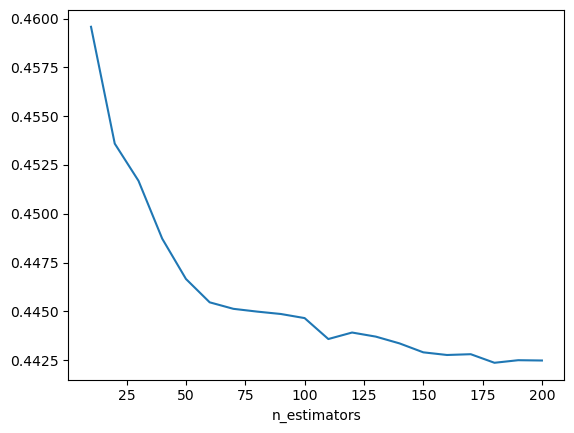

In [18]:
df_results.set_index('n_estimators')['RMSE_val'].plot();

Ans: 80

### Question 4

Let's select the best max_depth:

* Try different values of `max_depth`: [10, 15, 20, 25]
* For each of these values,
  + try different values of `n_estimators` from 10 till 200 (with step 10)
  + calculate the mean RMSE
* Fix the random seed: `random_state=1`

In [23]:
# What's the best max_depth, using the mean RMSE?
results = []
for max_depth in tqdm([10, 15, 20, 25]):
    scores = []
    for n_estimators in range(10,210,10): 
    
        model = RandomForestRegressor(max_depth=max_depth, n_estimators=n_estimators, random_state=1, n_jobs=-1)
        model.fit(X_train, y_train)

        y_pred_val = model.predict(X_val)
        score_val = root_mean_squared_error(y_val, y_pred_val)

        scores.append(score_val)
    
    results.append([max_depth, np.mean(scores)])

df_results = pd.DataFrame(results, columns=['max_depth','mean_RMSE_val'])
df_results.sort_values(by='mean_RMSE_val')

100%|█████████████████████████| 4/4 [01:41<00:00, 25.27s/it]


,max_depth,mean_RMSE_val
0,10,0.441808
1,15,0.445417
3,25,0.445910
2,20,0.446253


Ans: 10

### Question 5

We can extract feature importance information from tree-based models.

At each step of the decision tree learning algorithm, it finds the best split. When doing it, we can calculate "gain" - the reduction in impurity before and after the split. This gain is quite useful in understanding what are the important features for tree-based models.

Train the model with these parameters:
* n_estimators=10,
* max_depth=20,
* random_state=1,
* n_jobs=-1 (optional)

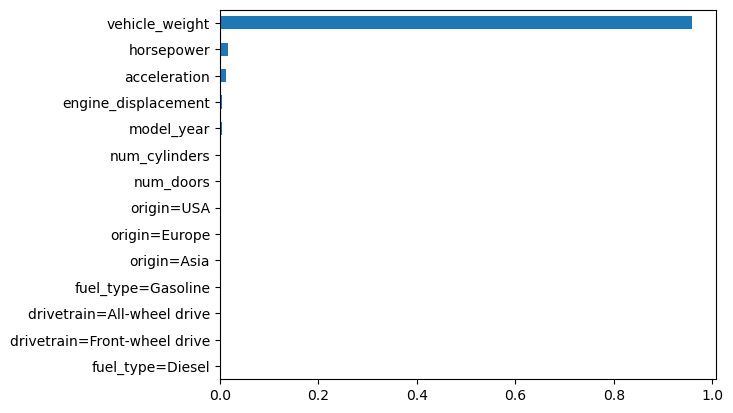

In [24]:
model = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
model.fit(X_train, y_train)

score = pd.Series(index = dv.feature_names_,
                  data = model.feature_importances_).sort_values()

score.plot(kind='barh');

What's the most important feature (among these 4)?

Ans: vehicle_weight

### Question 6

Now let's train an XGBoost model

In [25]:
# Create DMatrix for train and validation
dtrain = xgb.DMatrix(X_train, y_train, feature_names=dv.feature_names_)
dval = xgb.DMatrix(X_val, y_val, feature_names=dv.feature_names_)

In [26]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

In [27]:
model = xgb.train(xgb_params,
                  dtrain, 
                  num_boost_round=100, 
                  evals=[(dtrain,'train'),(dval,'val')],
                  verbose_eval=25
                 )

[0]	train-rmse:1.81393	val-rmse:1.85444
[25]	train-rmse:0.32268	val-rmse:0.43683
[50]	train-rmse:0.28456	val-rmse:0.44140
[75]	train-rmse:0.24792	val-rmse:0.44628
[99]	train-rmse:0.21950	val-rmse:0.45018


In [28]:
# Now change eta from 0.3 to 0.1
xgb_params['eta'] = 0.1

model = xgb.train(xgb_params,
                  dtrain, 
                  num_boost_round=100, 
                  evals=[(dtrain,'train'),(dval,'val')],
                  verbose_eval=25
                 )

[0]	train-rmse:2.28944	val-rmse:2.34561
[25]	train-rmse:0.41881	val-rmse:0.46891
[50]	train-rmse:0.33998	val-rmse:0.42498
[75]	train-rmse:0.31895	val-rmse:0.42526
[99]	train-rmse:0.30419	val-rmse:0.42623


Which eta leads to the best RMSE score on the validation dataset?

Ans: 0.1